In [1]:
import re
import string

# !pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup


[nltk_data] Downloading package punkt to /home/superio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/superio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [2]:
df = pd.read_csv("job_listings.csv").drop(columns=["Unnamed: 0"])
df

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist
5,b'<div>Create various Business Intelligence An...,Data Scientist
6,b'<div><p>As Spotify Premium swells to over 96...,Associate Data Scientist – Premium Analytics
7,"b""Everytown for Gun Safety, the nation's large...",Data Scientist
8,"b""<ul><li>MS in a quantitative discipline such...",Sr. Data Scientist
9,b'<div><p>Slack is hiring experienced data sci...,"Data Scientist, Lifecyle"


## 2) Use NLTK to tokenize / clean the listings 

In [3]:
# Removing numbers and comma before description text
df.description = df.description.str.lstrip('1234567890,').str.strip('b\"\'')
df.description = df.description.str.replace('<[^<]+?>', '')
df.description = df.description.replace('\n','', regex=False)
df.description = df.description.apply(lambda x:x.replace('\\n', ' '))
df.description = df.description.apply(lambda x:x.replace('\xe2\x80\x93', ' '))

In [4]:
# FROM LECTURE
import string
table = str.maketrans('','', string.punctuation)
stop_words = set(stopwords.words('english'))

def tokenize(texts):
    # Tokenize by word
    tokens = word_tokenize(texts)
#     print("Tokens:", tokens)
    # Make all words lowercase
    lowercase_tokens = [w.lower() for w in tokens]
#     print("Lowercase:", lowercase_tokens)
    # Strip punctuation from within words
    no_punctuation = [x.translate(table) for x in lowercase_tokens]
#     print("No Punctuation:", no_punctuation)
    # Remove words that aren't alphabetic
    alphabetic = [word for word in no_punctuation if word.isalpha()]
#     print("Alphabetic:", alphabetic)
    # Remove stopwords
    words = [w for w in alphabetic if not w in stop_words]
#     print("Cleaned Words:", words)
    return words

df['tokenized_description'] = df['description'].apply(tokenize)
df['tokenized_title'] = df['title'].apply(tokenize)

df

,description,title,tokenized_description,tokenized_title
0,Job Requirements: Conceptual understanding in ...,Data scientist,"[job, requirements, conceptual, understanding,...","[data, scientist]"
1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I,"[job, description, data, scientist, help, us, ...","[data, scientist]"
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, side, b...","[data, scientist, entry, level]"
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[monthcontractunder, general, supervision, pro...","[data, scientist]"
4,Location: USA \xe2\x80\x93 multiple locations ...,Data Scientist,"[location, usa, multiple, locations, years, an...","[data, scientist]"
5,Create various Business Intelligence Analytica...,Data Scientist,"[create, various, business, intelligence, anal...","[data, scientist]"
6,As Spotify Premium swells to over 96M subscrib...,Associate Data Scientist – Premium Analytics,"[spotify, premium, swells, subscribers, around...","[associate, data, scientist, premium, analytics]"
7,"Everytown for Gun Safety, the nation's largest...",Data Scientist,"[everytown, gun, safety, nation, largest, gun,...","[data, scientist]"
8,MS in a quantitative discipline such as Statis...,Sr. Data Scientist,"[ms, quantitative, discipline, statistics, mat...","[sr, data, scientist]"
9,Slack is hiring experienced data scientists to...,"Data Scientist, Lifecyle","[slack, hiring, experienced, data, scientists,...","[data, scientist, lifecyle]"


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [5]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# FROM LECTURE
# lemmatize
################################ 
lemmatizer = WordNetLemmatizer()
lemmatized_listings = []
for listing in [i for i in df.tokenized_description]:
    lemmas = [lemmatizer.lemmatize(word) for word in listing]
    lemmatized_listings.append(lemmas)

# List of document strings as text
lemmatized_listings

# Instantiate vectorizer object
vectorizer = CountVectorizer()
# Create a vocabulary and get word counts per document
bag_of_words = vectorizer.fit_transform(lemmatized_listings[0])
# Print word counts
print(bag_of_words.toarray())

# Get feature names to use as dataframe column headers
feature_names = vectorizer.get_feature_names()

df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
df.head()

[nltk_data] Downloading package wordnet to /home/superio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


,ability,along,apply,apriori,article,bayes,clean,coding,communicate,conceptual,...,stake,statisticsmathematicscomputer,svm,technical,tidyr,tree,understanding,via,work,write
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

<FreqDist with 79 samples and 83 outcomes>


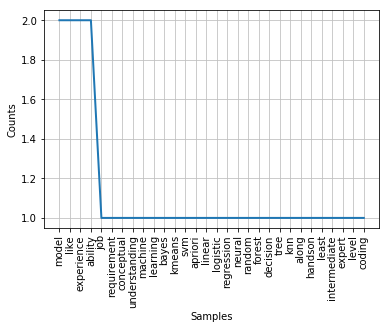

In [6]:
from nltk.probability import FreqDist

fdist = FreqDist(lemmatized_listings[0])
print(fdist)

fdist.most_common(20)

import matplotlib.pyplot as plt
fdist.plot(30, cumulative=False)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# List of document strings as text
text = lemmatized_listings[0]
# Instantiate vectorizer object
tfidf = TfidfVectorizer(max_features = 20)
# Create a vocabulary and get word counts per document
feature_matrix = tfidf.fit_transform(text)
# Print word counts
print(feature_matrix.toarray())

# Get feature names to use as dataframe column headers
feature_names = tfidf.get_feature_names()

# View Feature Matrix as DataFrame
df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
df.head()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,ability,experience,like,master,matplotlib,model,must,neural,nontechnical,numpy,package,panda,past,programming,published,python,pythonr,quant,random,regression
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.